<a href="https://colab.research.google.com/github/pufeiyang/Deep_Learning_Regression/blob/main/DenseNet_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet


In [1]:
"""DenseNet 1DCNN in Tensorflow-Keras
Reference: Densely Connected Convolutional Networks [https://arxiv.org/abs/1608.06993]
"""

import tensorflow as tf


def Conv_1D_Block(x, model_width, kernel, strides):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, strides=strides, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def stem(inputs, num_filters):
    # Construct the Stem Convolution Group
    # inputs : input vector
    conv = Conv_1D_Block(inputs, num_filters, 7, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="same")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding="same")(conv)

    return pool


def conv_block(x, num_filters, bottleneck=True):
    # Construct Block of Convolutions without Pooling
    # x        : input into the block
    # n_filters: number of filters
    if bottleneck:
        num_filters_bottleneck = num_filters * 4
        x = Conv_1D_Block(x, num_filters_bottleneck, 1, 1)

    out = Conv_1D_Block(x, num_filters, 3, 1)

    return out


def dense_block(x, num_filters, num_layers, bottleneck=True):
    for i in range(num_layers):
        cb = conv_block(x, num_filters, bottleneck=bottleneck)
        x = tf.keras.layers.concatenate([x, cb], axis=-1)

    return x


def transition_block(inputs, num_filters):
    x = Conv_1D_Block(inputs, num_filters, 1, 2)
    if x.shape[1] <= 2:
        x = tf.keras.layers.AveragePooling1D(pool_size=1, strides=2, padding="same")(x)
    else:
        x = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2, padding="same")(x)

    return x


def classifier(inputs, class_number):
    # Construct the Classifier Group
    # inputs       : input vector
    # class_number : number of output classes
    out = tf.keras.layers.Dense(class_number, activation='softmax')(inputs)

    return out


def regressor(inputs, feature_number):
    # Construct the Regressor Group
    # inputs         : input vector
    # feature_number : number of output features
    out = tf.keras.layers.Dense(feature_number, activation='linear')(inputs)

    return out


class DenseNet:
    def __init__(self, length, num_channel, num_filters, problem_type='Regression',
                 output_nums=1, pooling='avg', dropout_rate=False, bottleneck=True):
        self.length = length
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.pooling = pooling
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck

    def MLP(self, x):
        if self.pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling1D()(x)
        elif self.pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling1D()(x)
        # Final Dense Outputting Layer for the outputs
        x = tf.keras.layers.Flatten(name='flatten')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        return outputs

    def DenseNet121(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        stem_block = stem(inputs, self.num_filters)  # The Stem Convolution Group
        Dense_Block_1 = dense_block(stem_block, self.num_filters * 2, 6, bottleneck=self.bottleneck)
        Transition_Block_1 = transition_block(Dense_Block_1, self.num_filters)
        Dense_Block_2 = dense_block(Transition_Block_1, self.num_filters * 4, 12, bottleneck=self.bottleneck)
        Transition_Block_2 = transition_block(Dense_Block_2, self.num_filters)
        Dense_Block_3 = dense_block(Transition_Block_2, self.num_filters * 8, 24, bottleneck=self.bottleneck)
        Transition_Block_3 = transition_block(Dense_Block_3, self.num_filters)
        Dense_Block_4 = dense_block(Transition_Block_3, self.num_filters * 16, 16, bottleneck=self.bottleneck)
        outputs = self.MLP(Dense_Block_4)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def DenseNet161(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        stem_block = stem(inputs, self.num_filters)  # The Stem Convolution Group
        Dense_Block_1 = dense_block(stem_block, self.num_filters * 2, 6, bottleneck=self.bottleneck)
        Transition_Block_1 = transition_block(Dense_Block_1, self.num_filters * 2)
        Dense_Block_2 = dense_block(Transition_Block_1, self.num_filters * 4, 12, bottleneck=self.bottleneck)
        Transition_Block_2 = transition_block(Dense_Block_2, self.num_filters * 4)
        Dense_Block_3 = dense_block(Transition_Block_2, self.num_filters * 8, 36, bottleneck=self.bottleneck)
        Transition_Block_3 = transition_block(Dense_Block_3, self.num_filters * 8)
        Dense_Block_4 = dense_block(Transition_Block_3, self.num_filters * 16, 24, bottleneck=self.bottleneck)
        outputs = self.MLP(Dense_Block_4)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def DenseNet169(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        stem_block = stem(inputs, self.num_filters)  # The Stem Convolution Group
        Dense_Block_1 = dense_block(stem_block, self.num_filters * 2, 6, bottleneck=self.bottleneck)
        Transition_Block_1 = transition_block(Dense_Block_1, self.num_filters * 2)
        Dense_Block_2 = dense_block(Transition_Block_1, self.num_filters * 4, 12, bottleneck=self.bottleneck)
        Transition_Block_2 = transition_block(Dense_Block_2, self.num_filters * 4)
        Dense_Block_3 = dense_block(Transition_Block_2, self.num_filters * 8, 32, bottleneck=self.bottleneck)
        Transition_Block_3 = transition_block(Dense_Block_3, self.num_filters * 8)
        Dense_Block_4 = dense_block(Transition_Block_3, self.num_filters * 16, 32, bottleneck=self.bottleneck)
        outputs = self.MLP(Dense_Block_4)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def DenseNet201(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        stem_block = stem(inputs, self.num_filters)  # The Stem Convolution Group
        Dense_Block_1 = dense_block(stem_block, self.num_filters * 2, 6, bottleneck=self.bottleneck)
        Transition_Block_1 = transition_block(Dense_Block_1, self.num_filters)
        Dense_Block_2 = dense_block(Transition_Block_1, self.num_filters * 4, 12, bottleneck=self.bottleneck)
        Transition_Block_2 = transition_block(Dense_Block_2, self.num_filters)
        Dense_Block_3 = dense_block(Transition_Block_2, self.num_filters * 8, 48, bottleneck=self.bottleneck)
        Transition_Block_3 = transition_block(Dense_Block_3, self.num_filters)
        Dense_Block_4 = dense_block(Transition_Block_3, self.num_filters * 16, 32, bottleneck=self.bottleneck)
        outputs = self.MLP(Dense_Block_4)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model

    def DenseNet264(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        stem_block = stem(inputs, self.num_filters)  # The Stem Convolution Group
        Dense_Block_1 = dense_block(stem_block, self.num_filters * 2, 6, bottleneck=self.bottleneck)
        Transition_Block_1 = transition_block(Dense_Block_1, self.num_filters * 2)
        Dense_Block_2 = dense_block(Transition_Block_1, self.num_filters * 4, 12, bottleneck=self.bottleneck)
        Transition_Block_2 = transition_block(Dense_Block_2, self.num_filters * 4)
        Dense_Block_3 = dense_block(Transition_Block_2, self.num_filters * 8, 64, bottleneck=self.bottleneck)
        Transition_Block_3 = transition_block(Dense_Block_3, self.num_filters * 8)
        Dense_Block_4 = dense_block(Transition_Block_3, self.num_filters * 16, 48, bottleneck=self.bottleneck)
        outputs = self.MLP(Dense_Block_4)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model


# if __name__ == '__main__':
#     # Configurations
#     length = 1024  # Length of each Segment
#     model_name = 'DenseNet201'  # DenseNet Models
#     model_width = 16 # Width of the Initial Layer, subsequent layers start from here
#     num_channel = 1  # Number of Input Channels in the Model
#     problem_type = 'Regression' # Classification or Regression
#     output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
#     #
#     Model = DenseNet(length, num_channel, model_width, problem_type=problem_type, output_nums=output_nums, pooling='avg', dropout_rate=False, bottleneck=True).DenseNet201()
#     Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.MeanAbsoluteError(), metrics=tf.keras.metrics.MeanSquaredError())
#     Model.summary()

# Test GPU

In [2]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla T4
GPU Capability: (7, 5)
Is GPU Initialized yet? True


# Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report, auc, precision_recall_curve, average_precision_score
sns.set_theme(style="whitegrid")

# Upload Dataset 

In [4]:
df = pd.read_excel('/content/dataset.xlsx')
print(df.shape)

(336, 145)


# Train-Test Split

In [5]:
x_data = df.iloc[:,3:].values
y_data = df.iloc[:,2].values

print(x_data.shape)
print(y_data.shape)

(336, 142)
(336,)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(268, 142)
(68, 142)
(268,)
(68,)


In [7]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(268, 142, 1) (68, 142, 1)
(268,) (68,)


# Build and Train Imported Data using the Regression Model

In [8]:
"Configurations for DenseNet in Regression Mode"
length = x_train.shape[1]   # Number of Features (or length of the signal)
model_width = 32            # Number of Filter or Kernel in the Input Layer (Power of 2 to avoid error)
num_channel = 1             # Number of Input Channels
problem_type = 'Regression' # Regression or Classification
output_number = 1           # Number of Outputs in the Regression Mode - 1 input is mapped to a single output

In [9]:
Regression_Model = DenseNet(length, num_channel, model_width, problem_type=problem_type, output_nums=output_number).DenseNet169() # Build Model
Regression_Model.compile(loss='mae', optimizer='adam', metrics= ['mse']) # Compile Model

In [10]:
Regression_Model.summary() # Summary of the Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 142, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 71, 32)       256         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 71, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 71, 32)       0           ['batch_normalization[0][0]']

In [11]:
# Early Stopping and Model_Checkpoints are optional parameters
# Early Stopping is to stop the training based on certain condition set by the user
# Model Checkpoint is to save a model in a directory based on certain conditions so that it can be used later for Transfer Learning or avoiding retraining
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min'), 
             tf.keras.callbacks.ModelCheckpoint('trained_models/DenseNet169_'+str(model_width)+'_'+str(num_channel)+'_'+str(output_number)+'_'+str(problem_type)+'.h5', 
                                                verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
history = Regression_Model.fit(x_train, y_train, epochs=500, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)
# Save 'History' of the model for model performance analysis performed later

Epoch 1/500
2/2 [==============================] - ETA: 0s - loss: 25.0502 - mse: 653.9918  
Epoch 1: val_loss improved from inf to 20301.41211, saving model to trained_models/DenseNet169_32_1_1_Regression.h5
2/2 [==============================] - 179s 88s/step - loss: 25.0502 - mse: 653.9918 - val_loss: 20301.4121 - val_mse: 475926912.0000
Epoch 2/500
2/2 [==============================] - ETA: 0s - loss: 15.5702 - mse: 273.2664
Epoch 2: val_loss did not improve from 20301.41211
2/2 [==============================] - 4s 3s/step - loss: 15.5702 - mse: 273.2664 - val_loss: 36949000.0000 - val_mse: 1572305117380608.0000
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 7.6919 - mse: 77.4448
Epoch 3: val_loss did not improve from 20301.41211
2/2 [==============================] - 4s 3s/step - loss: 7.6919 - mse: 77.4448 - val_loss: 4716223488.0000 - val_mse: 26089024986892206080.0000
Epoch 4/500
2/2 [==============================] - ETA: 0s - loss: 6.1078 - mse: 149.4821

In [12]:
Predictions = Regression_Model.predict(x_test, verbose=1)
print(Predictions.shape)

3/3 [==============================] - 13s 2s/step
(68, 1)


In [13]:
# Error of the prediction, one of many evaluation metrics
# Using Mean Absolute Error (MAE) in this case as a sample
Error = mean_absolute_error(y_test, Predictions)
print(f"MAE: {Error}")

MAE: 74729.18098898495


dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


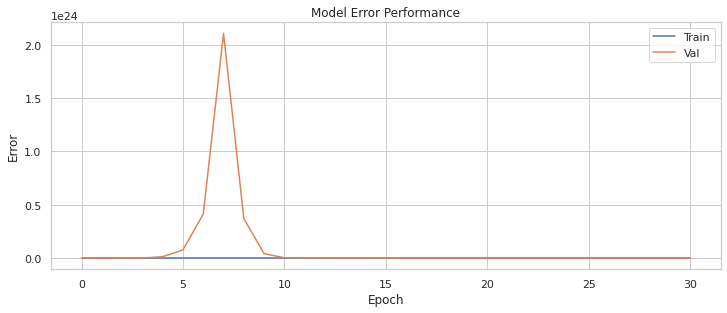

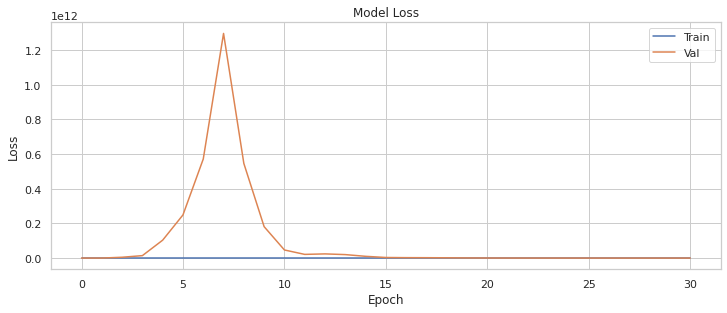

In [14]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,1)
  plt.plot(history.history['mse'])
  plt.plot(history.history['val_mse'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(12,10))
  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
#
history_plot(history)

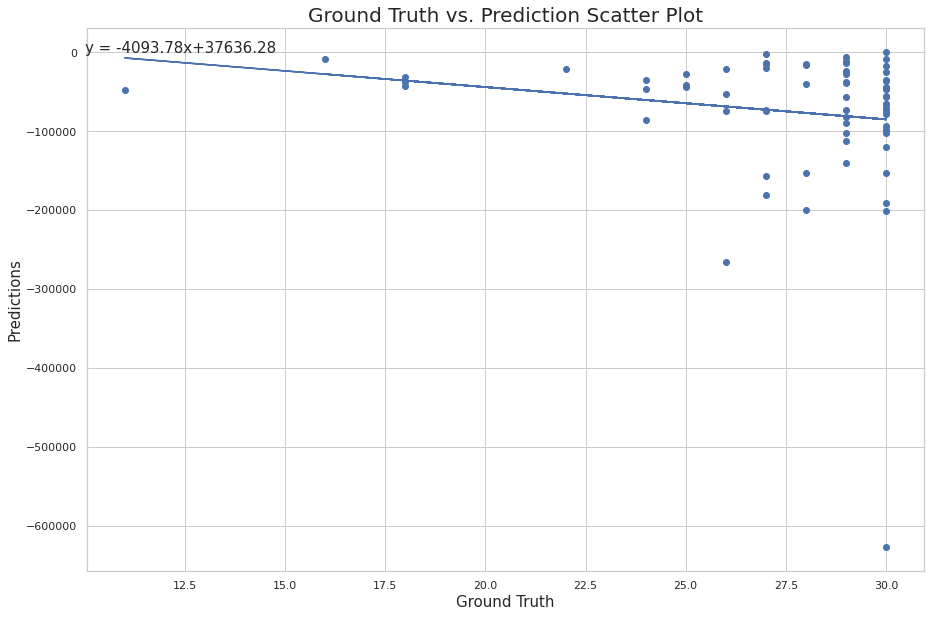

In [15]:
def plot_prediction(test_labels, test_predictions):
  plt.figure(figsize=(15,10))
  plt.scatter(test_labels, test_predictions)
  '''Add Trendline'''
  z = np.polyfit(test_labels.ravel(), test_predictions.ravel(), 1)
  p = np.poly1d(z)
  plt.plot(test_labels, p(test_labels))
  plt.text(np.max(test_labels)/3,np.max(test_predictions),f'y = {p[1]:.2f}x+{p[0]:.2f}', fontsize=15)
  plt.title('Ground Truth vs. Prediction Scatter Plot', fontsize=20)
  plt.xlabel('Ground Truth', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
#
plot_prediction(y_test, Predictions)

Text(0, 0.5, 'Density')

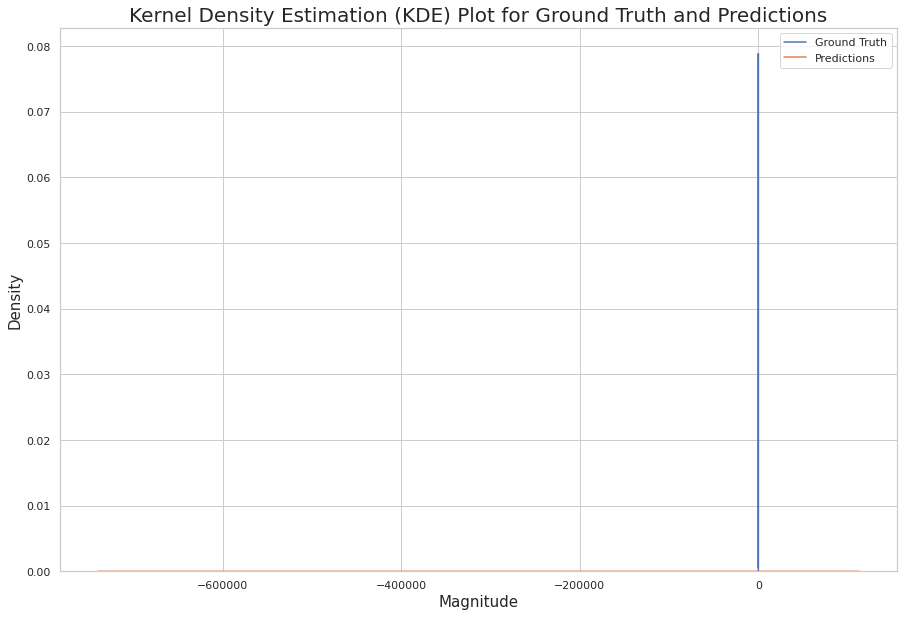

In [16]:
df = pd.DataFrame(data = {'Ground Truth': y_test.ravel(), 'Predictions': Predictions.ravel()})
plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.kdeplot(data=df)
plt.title('Kernel Density Estimation (KDE) Plot for Ground Truth and Predictions', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)

Text(0, 0.5, 'Magnitude')

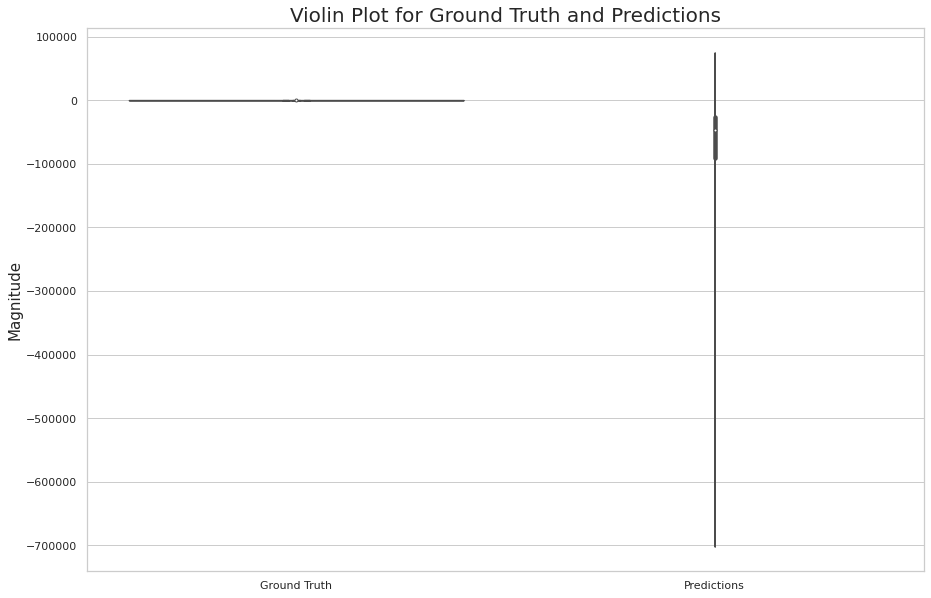

In [17]:
plt.figure(figsize = (15,10))
df = pd.DataFrame(data = {'Ground Truth': y_test.ravel(), 'Predictions': Predictions.ravel()})
ax = sns.violinplot(data=df)
plt.title('Violin Plot for Ground Truth and Predictions', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)